# Sepsis Cases Project


In [73]:
import pm4py
import pandas as pd
import pm4py
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.analysis.woflan import algorithm as woflan
from IPython.display import display
from pm4py.algo.analysis.woflan import algorithm as woflan
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.decision_mining import algorithm as decision_mining
from pm4py.visualization.petri_net import visualizer
from pm4py.visualization.decisiontree import visualizer as tree_visualizer
from sklearn import tree


#### Load the CSV and XES files

In [74]:
df = pd.read_csv('Sepsis Cases - Event Log.csv')
log = pm4py.read_xes("Sepsis Cases - Event Log.xes", variant="iterparse20")

df.head()

,Unnamed: 0,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,0,True,A,True,True,True,True,True,True,True,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN


In [75]:
n_traces = len(log["case:concept:name"].unique())
print(f"number of traces: {n_traces}")

number of traces: 1050


In [76]:
# Group by 'case_id' and concatenate the events for each trace
trace_df = df.groupby('case:concept:name')['org:group'].apply(lambda x: ','.join(x)).reset_index()

# Count the occurrences of each unique trace
trace_counts = trace_df['org:group'].value_counts()

# Rename the column for display purposes
trace_counts = trace_counts.rename_axis('Trace').reset_index(name='Count')

# Print the results without the index
print(trace_counts.head(10).to_string(index=False))

                    Trace  Count
                A,C,A,B,B     46
          A,C,A,B,B,B,A,A     42
                    A,C,A     31
              A,C,A,B,B,B     21
          A,C,A,A,A,B,B,B     10
          A,C,B,B,B,A,A,A      9
          A,C,A,A,B,B,B,A      9
                A,C,B,B,A      7
  A,C,A,B,B,B,A,A,O,B,B,E      7
A,C,A,B,B,B,A,A,F,B,B,E,?      7


In [77]:
activity_attribute = "concept:name"
activities = log.groupby(activity_attribute)[activity_attribute].count()
resource_attribute = "org:group"
activities_resources = log.groupby(activity_attribute)[resource_attribute].unique().agg(", ".join)
display(pd.merge(activities, activities_resources, left_index=True, right_index=True)["org:group"])

C:\Users\mayan\AppData\Local\Temp\ipykernel_11360\3462307038.py:4: FutureWarning: using <built-in method join of str object at 0x00000191E807A5B0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  activities_resources = log.groupby(activity_attribute)[resource_attribute].unique().agg(", ".join)


concept:name
Admission IC                                                        J, P, K, W
Admission NC        D, F, G, H, I, J, K, M, N, O, Q, R, S, T, U, V, P, X, W, Y
CRP                                                                          B
ER Registration                                                           A, L
ER Sepsis Triage                                                          A, L
ER Triage                                                                    C
IV Antibiotics                                                            A, L
IV Liquid                                                                 A, L
LacticAcid                                                                   B
Leucocytes                                                                   B
Release A                                                                    E
Release B                                                                    E
Release C                              

#### Most common process variants

In [78]:
variants = pm4py.get_variants(log)
common_variants = pd.DataFrame(variants.items(), columns=["variant", "count"]).sort_values("count", ascending=False)
common_variants["percentile"] = common_variants["count"] / common_variants["count"].sum() * 100
pd.set_option("display.max_colwidth", None)
common_variants.head(10)[["variant", "count", "percentile"]]

,variant,count,percentile
21,"(ER Registration, ER Triage, ER Sepsis Triage)",35,3.333333
24,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP)",24,2.285714
95,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes)",22,2.095238
3,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, LacticAcid, Leucocytes, IV Liquid, IV Antibiotics)",13,1.238095
36,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid)",11,1.047619
139,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics)",9,0.857143
1,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, LacticAcid, CRP, IV Liquid, IV Antibiotics)",7,0.666667
158,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.476190
232,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics)",5,0.476190
83,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, LacticAcid, IV Liquid, IV Antibiotics)",5,0.476190


In [79]:
start_activities = pm4py.stats.get_start_activities(log)
end_activities = pm4py.stats.get_end_activities(log)
print("Start activities:")
display(start_activities)
print("End activities:")
display(end_activities)

Start activities:


{'ER Registration': 995,
 'IV Liquid': 14,
 'ER Triage': 6,
 'CRP': 10,
 'ER Sepsis Triage': 7,
 'Leucocytes': 18}

End activities:


{'Release A': 393,
 'Return ER': 291,
 'IV Antibiotics': 87,
 'Release B': 55,
 'ER Sepsis Triage': 49,
 'Leucocytes': 44,
 'IV Liquid': 12,
 'Release C': 19,
 'CRP': 41,
 'LacticAcid': 24,
 'Release D': 14,
 'Admission NC': 14,
 'Release E': 5,
 'ER Triage': 2}

In [80]:
initial_log_len = len(log)

valid_star_activity = {"ER Registration"}
valid_end_activities = {"Release A", "Release B", "Release C", "Release D", "Release E", "Return ER"}

filtered_log = pm4py.filter_start_activities(log, valid_star_activity)
filtered_log = pm4py.filter_end_activities(filtered_log, valid_end_activities)

print("Filtered log length:", len(filtered_log))
print((initial_log_len - len(filtered_log))/initial_log_len)
n_traces = len(filtered_log["case:concept:name"].unique())
print(f"Remaining traces: {n_traces}")

Filtered log length: 12436
0.18259497830945182
Remaining traces: 734


In [81]:
start_activities = pm4py.stats.get_start_activities(filtered_log)
end_activities = pm4py.stats.get_end_activities(filtered_log)
print("Start activities:")
display(start_activities)
print("End activities:")
display(end_activities)

Start activities:


{'ER Registration': 734}

End activities:


{'Release A': 376,
 'Return ER': 275,
 'Release B': 49,
 'Release C': 16,
 'Release D': 13,
 'Release E': 5}

In [82]:
variants = pm4py.get_variants(filtered_log)
common_variants = pd.DataFrame(variants.items(), columns=["variant", "count"]).sort_values("count", ascending=False)
common_variants["percentile"] = common_variants["count"] / common_variants["count"].sum() * 100
pd.set_option("display.max_colwidth", None)
common_variants.head(10)[["variant", "count", "percentile"]]


,variant,count,percentile
122,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.681199
183,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics, Admission NC, Release A)",4,0.544959
48,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, Admission NC, Release A)",4,0.544959
213,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, LacticAcid, CRP, IV Liquid, IV Antibiotics, Admission NC, CRP, Leucocytes, Release A)",4,0.544959
269,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics, Admission NC, Leucocytes, CRP, Release A)",4,0.544959
34,"(ER Registration, ER Triage, ER Sepsis Triage, IV Liquid, Leucocytes, CRP, LacticAcid, IV Antibiotics, Admission NC, Leucocytes, CRP, Release A, Return ER)",3,0.408719
121,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics, Admission NC, CRP, Release A, Return ER)",3,0.408719
596,"(ER Registration, ER Triage, ER Sepsis Triage, IV Liquid, IV Antibiotics, Leucocytes, LacticAcid, CRP, Admission NC, Leucocytes, CRP, Release A, Return ER)",3,0.408719
126,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, LacticAcid, Leucocytes, IV Liquid, IV Antibiotics, Admission NC, Release A)",3,0.408719
342,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics, Admission NC, Leucocytes, CRP, CRP, Leucocytes, Release A)",2,0.272480


In [83]:

print(df.columns)

Index(['Unnamed: 0', 'InfectionSuspected', 'org:group', 'DiagnosticBlood',
       'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate',
       'Infusion', 'DiagnosticArtAstrup', 'concept:name', 'Age',
       'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor',
       'DiagnosticOther', 'SIRSCriteria2OrMore', 'DiagnosticXthorax',
       'SIRSCritTemperature', 'time:timestamp', 'DiagnosticUrinaryCulture',
       'SIRSCritLeucos', 'Oligurie', 'DiagnosticLacticAcid',
       'lifecycle:transition', 'Diagnose', 'Hypoxie',
       'DiagnosticUrinarySediment', 'DiagnosticECG', 'case:concept:name',
       'Leucocytes', 'CRP', 'LacticAcid'],
      dtype='object')


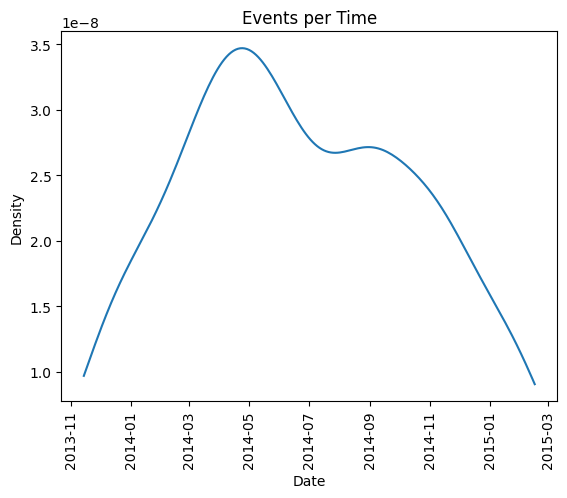

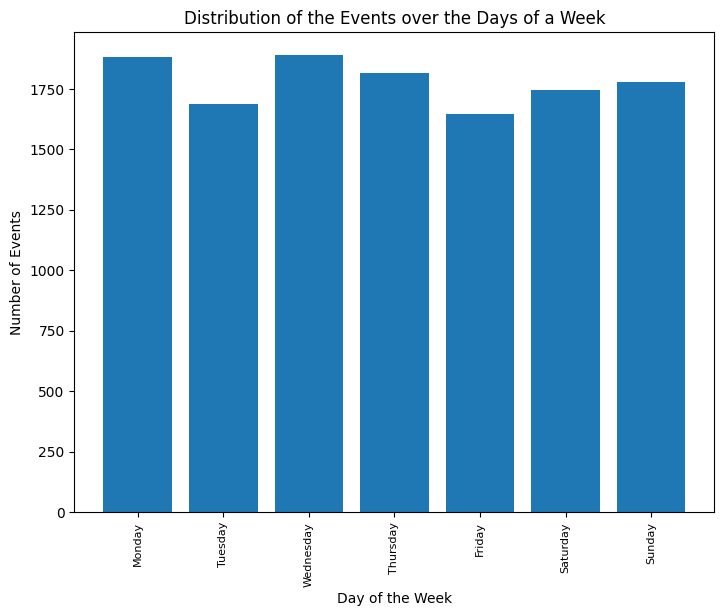

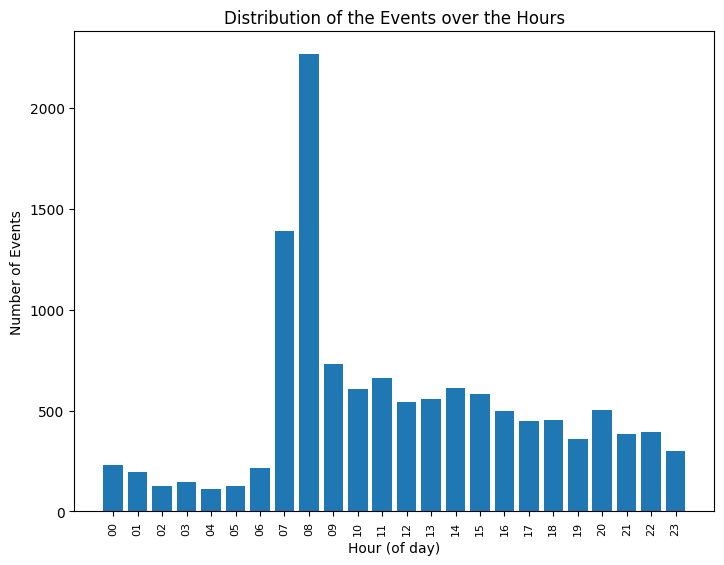

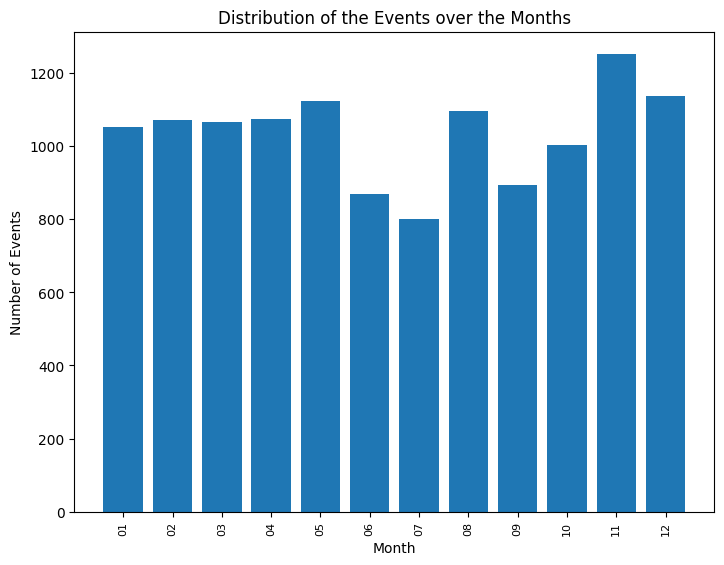

In [85]:
pm4py.view_events_per_time_graph(filtered_log)
pm4py.view_events_distribution_graph(filtered_log)
pm4py.view_events_distribution_graph(filtered_log, distr_type="hours")
pm4py.view_events_distribution_graph(filtered_log, distr_type="months")

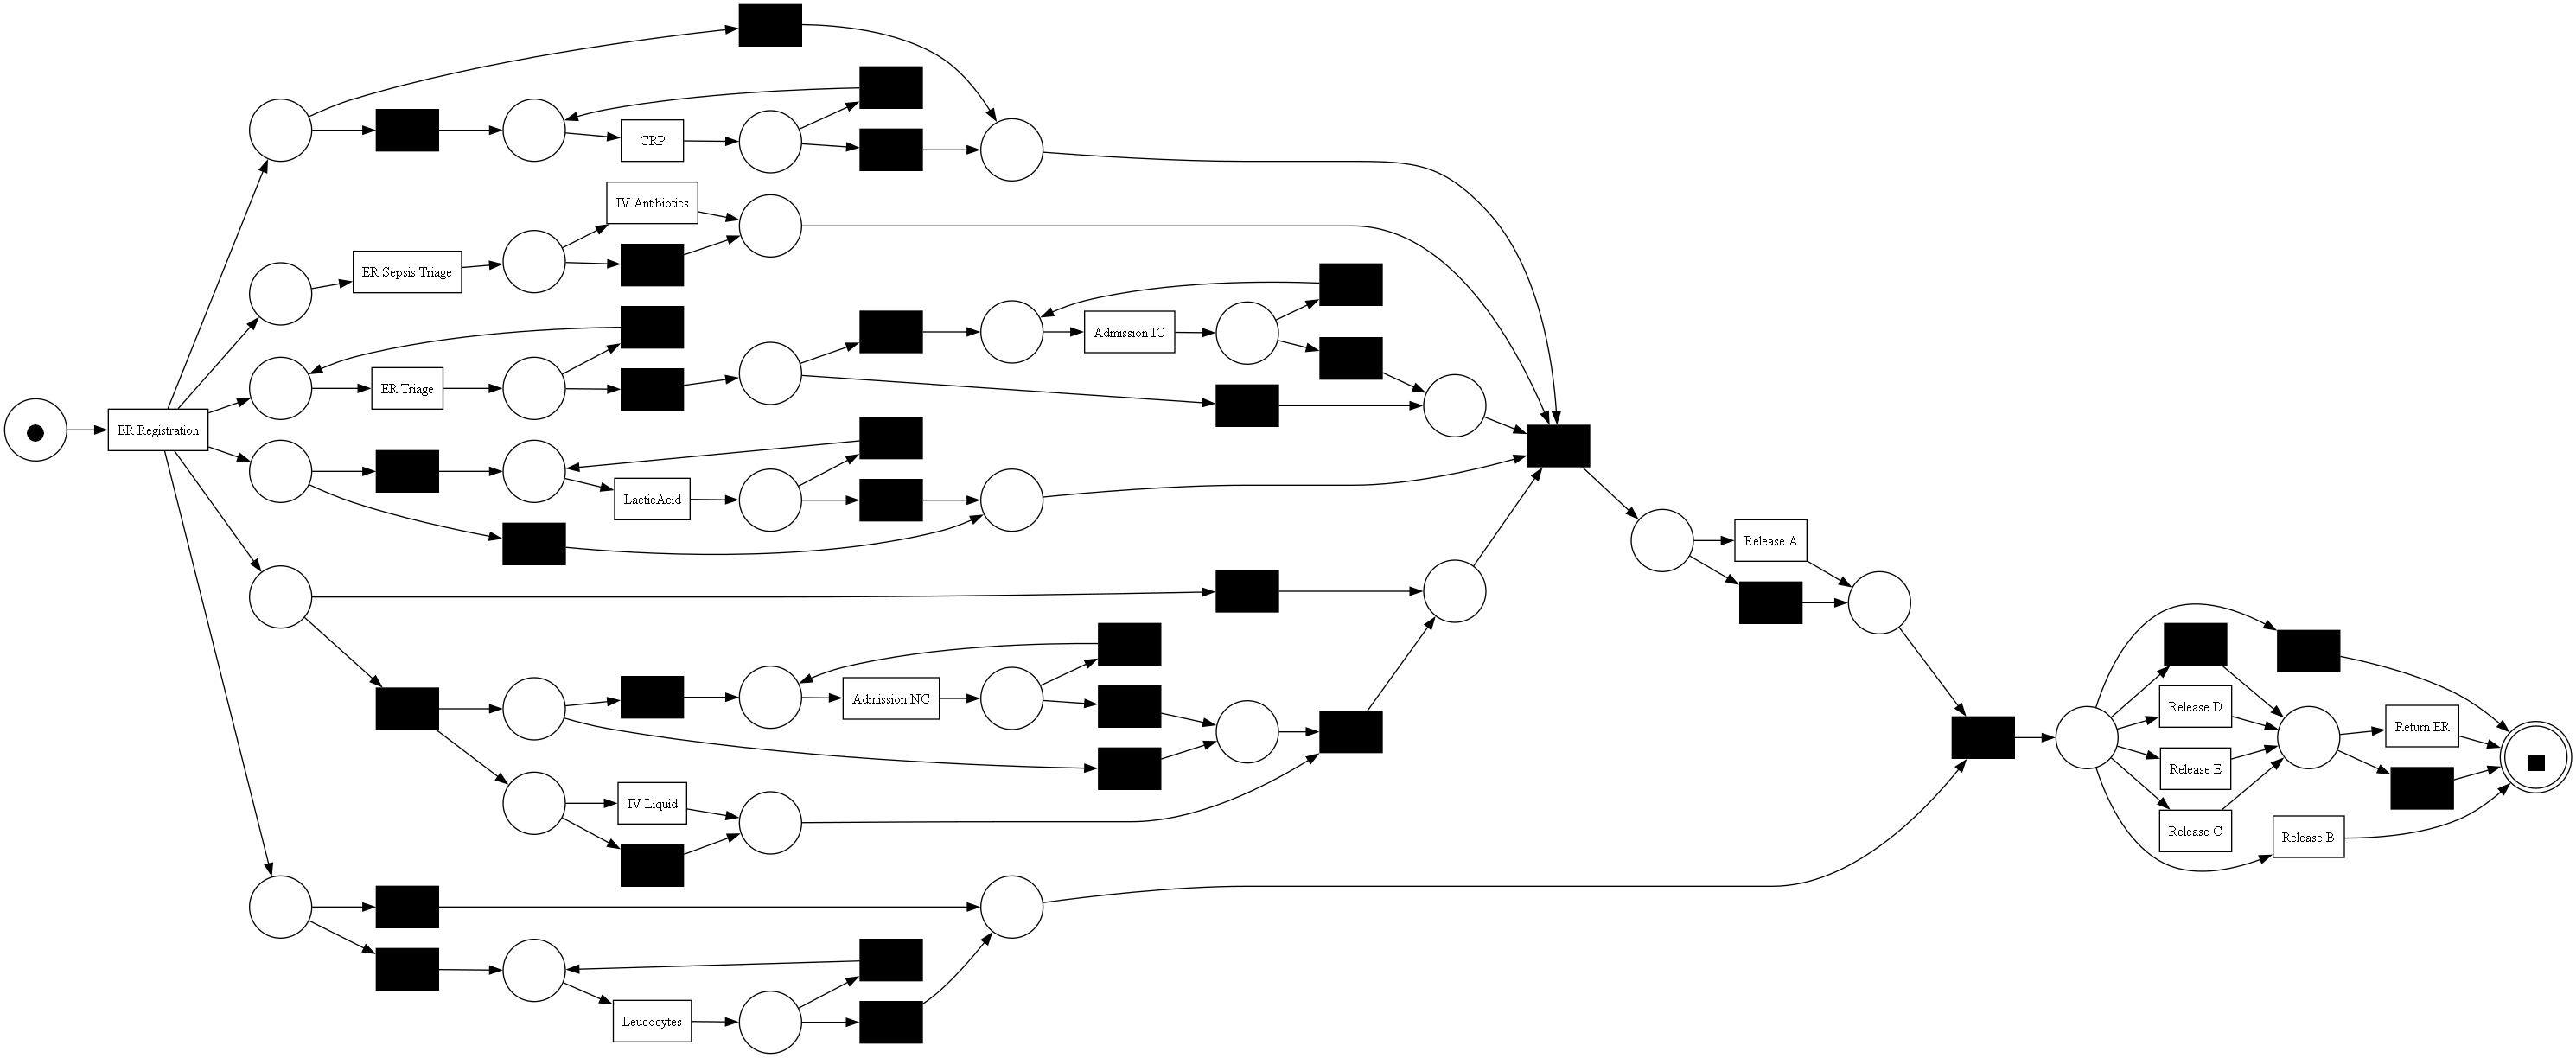

In [ ]:
pn1, im, fm = pm4py.discover_petri_net_inductive(filtered_log)
pm4py.view_petri_net(pn1, im, fm)


In [ ]:
def aligments(log, net):
    fitness = pm4py.fitness_alignments(log, *net)
    precision = pm4py.precision_alignments(log, *net)
    generalization = generalization_evaluator.apply(log, *net)
    simplicity = simplicity_evaluator.apply(net[0])


    # Create a DataFrame
    df = pd.DataFrame({
        "Metric": ["Average Fitness", "Precision", "Generalization", "Simplicity"],
        "Value": [fitness["averageFitness"], precision, generalization, simplicity]
    })

    # Print the DataFrame
    print(df)

In [ ]:
values_of_i = [1, 2, 3, 4, 5, 10, 20, 25,30, 35, len(common_variants)]

for i in values_of_i:
    # Filter the log for the first i variants
    current_log = pm4py.filter_variants_top_k(filtered_log, i)
    current_log_copy = current_log.copy()
        
    # Discover a Petri net for the most common variant
    pn_cur, im_cur, fm_cur = pm4py.discover_petri_net_alpha(current_log_copy)
    net = pm4py.discover_petri_net_alpha(current_log_copy)
    print(f"Alpha Petri Net for {i} most common variants")
    pm4py.view_petri_net(pn_cur, im_cur, fm_cur)


In [ ]:
for i in values_of_i:
    # Filter the log for the first i variants
    current_log = pm4py.filter_variants_top_k(filtered_log, i)
        
    # Discover a Petri net for the most common variant
    pn_cur, im_cur, fm_cur = pm4py.discover_petri_net_inductive(current_log)
    net= pm4py.discover_petri_net_inductive(current_log)
    print(f"Inductive Petri Net for {i} most common variants")
    pm4py.view_petri_net(pn_cur, im_cur, fm_cur)
    if i==1 or i==2 or i==3 or i==4: 
            print(f"Reachability graph for {i} most common variants")
            ts = reachability_graph.construct_reachability_graph(pn_cur, im_cur)
            gviz = ts_visualizer.apply(ts, parameters={ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT: "png"})
            ts_visualizer.view(gviz)
    aligments(filtered_log,net)



In [ ]:
woflan_parameters = {
    woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: False,
    woflan.Parameters.PRINT_DIAGNOSTICS: True,
    woflan.Parameters.RETURN_DIAGNOSTICS: False
}

## Soundeness check for our model

,variant,count,percentile
122,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.681199
183,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics, Admission NC, Release A)",4,0.544959
48,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, Admission NC, Release A)",4,0.544959


Inductive Petri Net for 3 most common variants


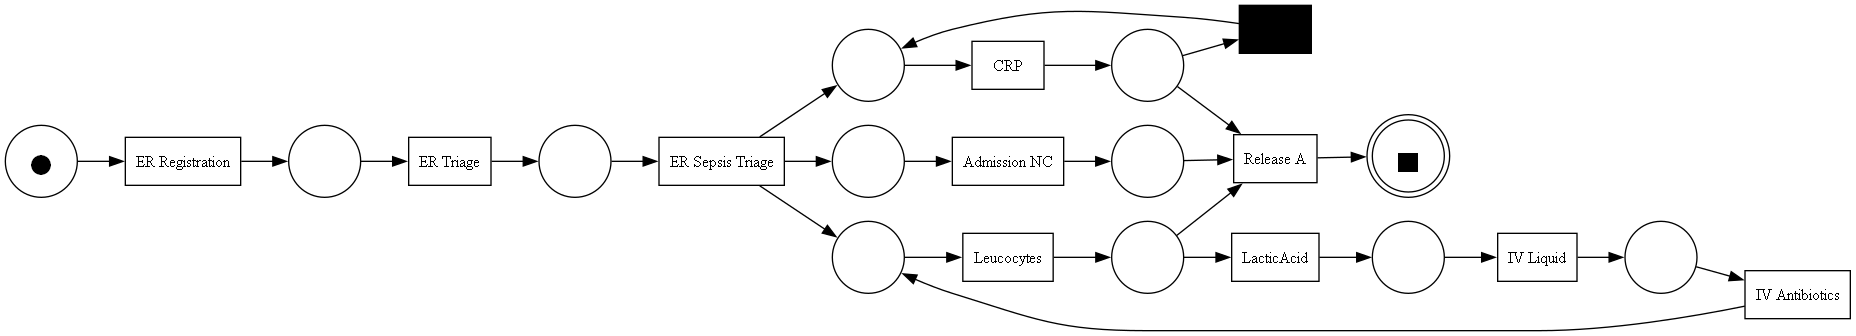

aligning log, completed variants :: 100%|██████████| 685/685 [00:18<00:00, 37.24it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [00:23<00:00, 220.89it/s]
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:01<00:00, 376.83it/s]


            Metric     Value
0  Average Fitness  0.766402
1        Precision  0.931965
2   Generalization  0.968088
3       Simplicity  0.793103
Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.
Is sound: True


c:\Users\mayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pm4py\algo\analysis\woflan\place_invariants\utility.py:153: UserWarning: solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.
  warnings.warn("solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.")


In [ ]:
values_of_i = [3]
for i in values_of_i:
    display(common_variants[0:i])
    # Filter the log for the first i variants
    current_log = pm4py.filter_variants_top_k(filtered_log, i)
    dataframe = pm4py.convert_to_dataframe(current_log)
    dataframe.to_csv('Sepsis_Cases_3_Most_Common.csv')
        
    # Discover a Petri net for the most common variant
    pn_cur, im_cur, fm_cur = pm4py.discover_petri_net_inductive(current_log)
    net= pm4py.discover_petri_net_inductive(current_log)
    print(f"Inductive Petri Net for {i} most common variants")
    wfnet_inductive = net
    pm4py.vis.view_petri_net(*wfnet_inductive)
    pm4py.vis.save_vis_petri_net(*wfnet_inductive, "final_inductive_petri_net.pdf")
    aligments(filtered_log,net)

    is_sound = woflan.apply(*wfnet_inductive, parameters=woflan_parameters)
    print(f"Is sound: {is_sound}")


In [ ]:
fitness = pm4py.fitness_alignments(filtered_log, *net)
precision = pm4py.precision_alignments(filtered_log, *net)
generalization = generalization_evaluator.apply(filtered_log, *net)
simplicity = simplicity_evaluator.apply(net[0])

pd.DataFrame({"Average Fitness": [fitness["averageFitness"]],
              "Precision": [precision],
              "Generalization": [generalization],
              "Simplicity": [simplicity]})

aligning log, completed variants :: 100%|██████████| 685/685 [00:20<00:00, 33.22it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [00:25<00:00, 200.89it/s]
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:01<00:00, 578.76it/s]


,Average Fitness,Precision,Generalization,Simplicity
0,0.766402,0.931965,0.968088,0.793103


replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:02<00:00, 247.79it/s]


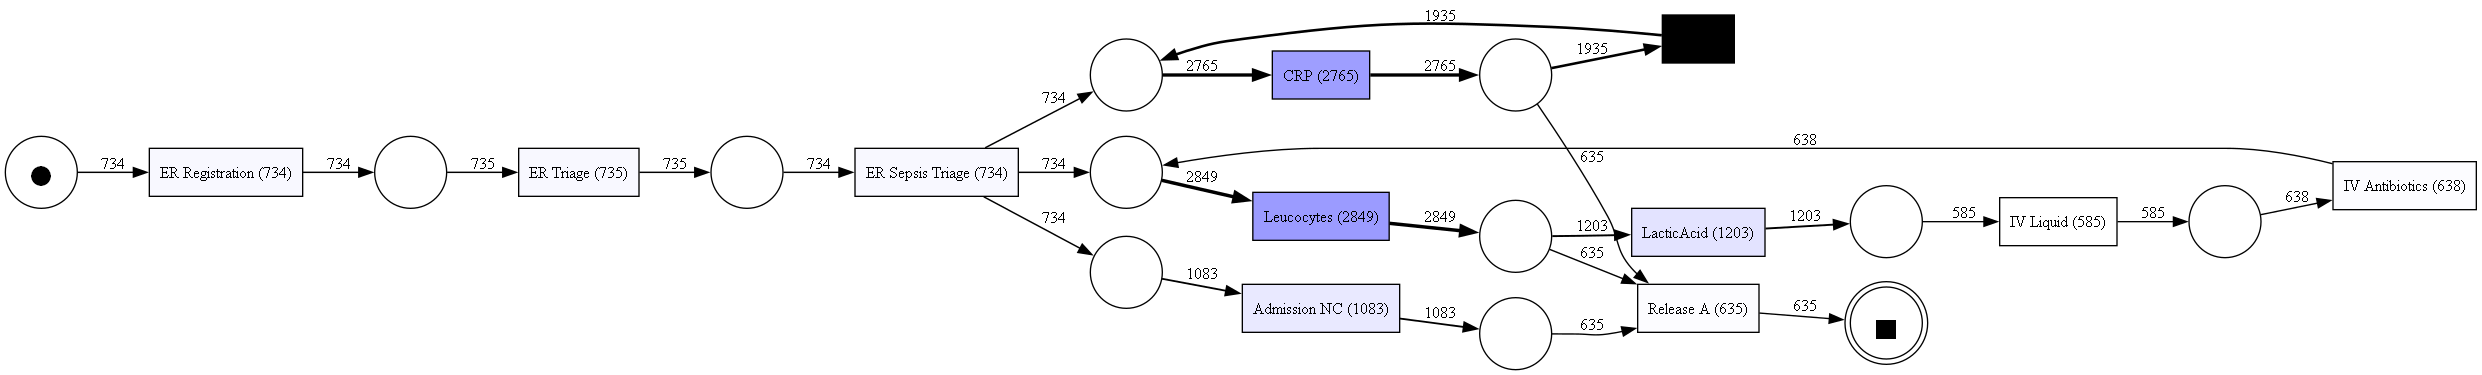

replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:01<00:00, 346.74it/s]


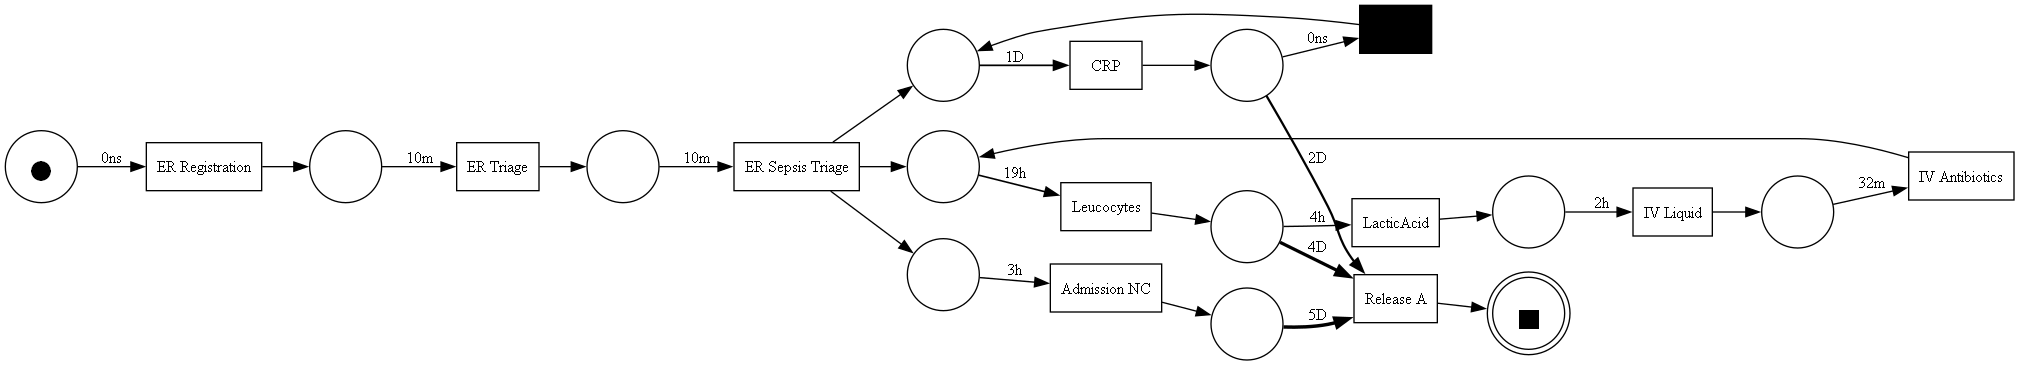

In [ ]:
# add frequencies
parameters_freq = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz_freq = pn_visualizer.apply(*net, parameters=parameters_freq, variant=pn_visualizer.Variants.FREQUENCY, log=filtered_log)
pn_visualizer.view(gviz_freq)


# add temporal information
parameters_temp = {pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
gviz_temp = pn_visualizer.apply(*net, parameters=parameters_temp, variant=pn_visualizer.Variants.PERFORMANCE, log=filtered_log)
pn_visualizer.view(gviz_temp)


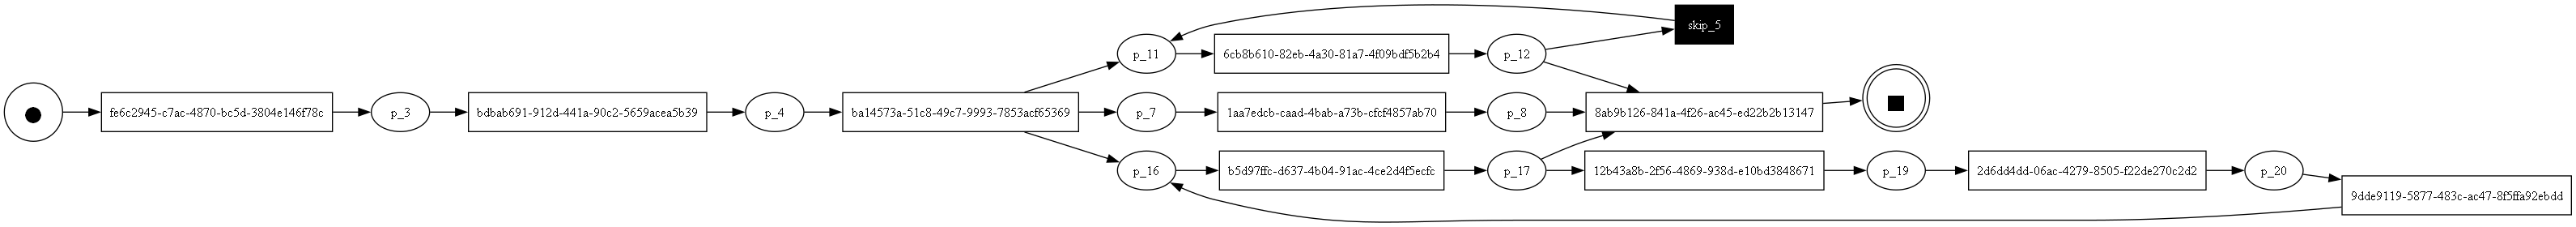

{'p_17': ['8ab9b126-841a-4f26-ac45-ed22b2b13147', '12b43a8b-2f56-4869-938d-e10bd3848671'], 'p_12': ['8ab9b126-841a-4f26-ac45-ed22b2b13147', 'skip_5']}


replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:00<00:00, 725.85it/s]


Decision point: p_12; possible decisions: ['skip_5', 'Release A', 'None']


c:\Users\mayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pm4py\algo\decision_mining\algorithm.py:533: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mod["Target"] = df_mod[target_column].replace(map_to_int)
C:\Users\mayan\AppData\Local\Temp\ipykernel_11360\2175754480.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0)


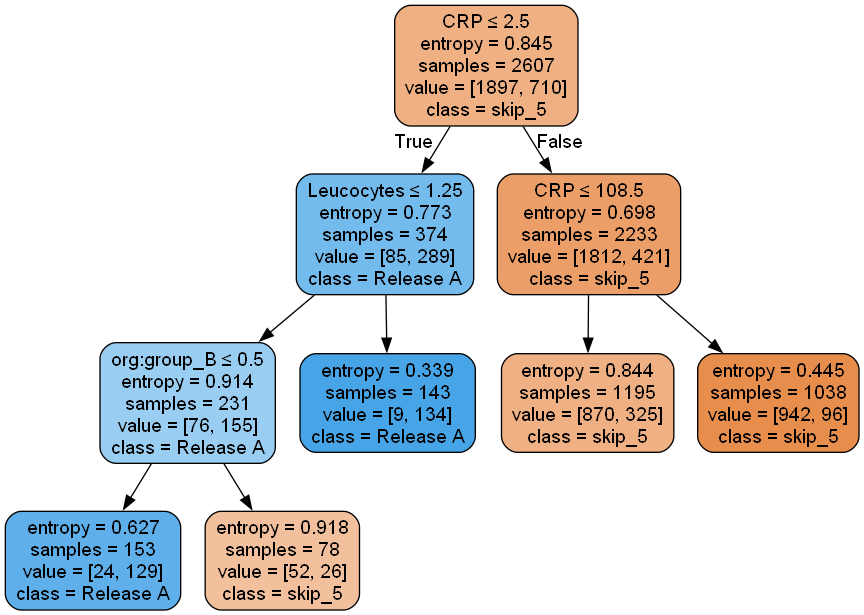

replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:01<00:00, 589.21it/s]


Decision point: p_17; possible decisions: ['LacticAcid', 'Release A']


c:\Users\mayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pm4py\algo\decision_mining\algorithm.py:533: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mod["Target"] = df_mod[target_column].replace(map_to_int)
C:\Users\mayan\AppData\Local\Temp\ipykernel_11360\2175754480.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0)


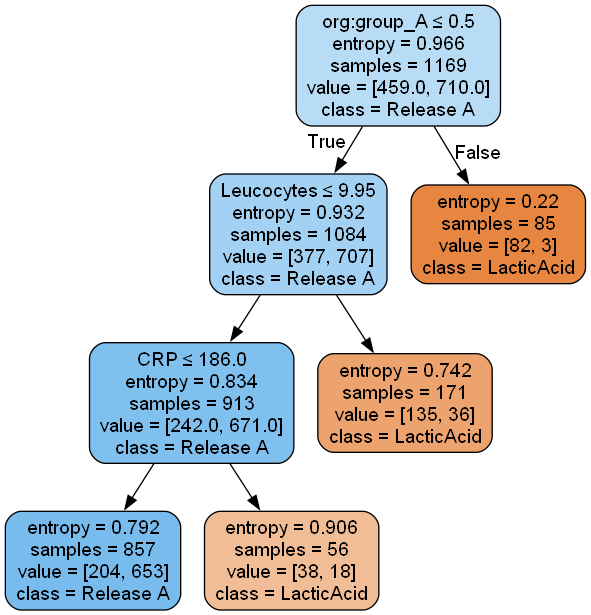

In [87]:
# View the identifiers of the nodes in the WF-net
gviz = visualizer.apply(*net, parameters={visualizer.Variants.WO_DECORATION.value.Parameters.DEBUG: True})
visualizer.view(gviz)

attributes = pm4py.get_event_attributes(filtered_log)
attributes = [att for att in attributes if "time" not in att]

decision_points = decision_mining.get_decision_points(net[0])
print(decision_points)
for point in sorted(decision_points.keys()):
  X, y, classes = decision_mining.apply(filtered_log, *net, decision_point=point, attributes=attributes,)
  X = X.fillna(0)
  X = X[~y.isna()]
  y = y[~y.isna()]
  classes = [str(c) for c in classes]

  print(f"Decision point: {point}; possible decisions: {classes}")

  dt = tree.DecisionTreeClassifier(max_depth=3, ccp_alpha=0.01,
                                   random_state=42, criterion="entropy")
  dt = dt.fit(X, y)
  feature_names = list(X.columns.values.tolist())

  gviz = tree_visualizer.apply(dt, feature_names, classes)
  tree_visualizer.view(gviz)

